## Train a cellpose 2D model 

This notebook shows how to train a Stardist model.  After training go back and load the model into ```napari-easy-augment-batch-dl``` to test the model.  

Before running this notebook a set of patches must exist in the following format.

1.  Ground Truth are put in a directory called ```/ground truth0```
2.  Inputs are put in a directory called ```inputn``` where n is an integer 0...m and represents the channel.  Note:  RGB images may only have one 'channel' directory.
3.  In each of the both directories there exist a set of files of the same names.  For example if in the ```inputn``` directory we have ```apples0```, ```apples1```, ```apples2``` label images of the same name must exist in the ```ground truth``` directory.  

In [1]:
import os
from tnia.plotting.plt_helper import imshow_multi2d
from cellpose import models, io
from pathlib import Path

## Load inputs and ground truth

We load directories called 'input0' and 'ground truth0' which should exist under ```train_path```.  The reason we append '0' to the end of the name is because some of the code that generates image and label sets is meant to work on multiple channels (so the 0 is the channel number)

In [2]:
tnia_images_path = Path(r"D:\images")
data_path = r'../../data'
parent_path = os.path.join(data_path, 'ladybugs1')

train_path = os.path.join(parent_path, 'patches')

image_patch_path = train_path + '/ground truth0'
label_patch_path = train_path + '/input0'

model_path = os.path.join(parent_path,'models')

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(image_patch_path):
    print('image_patch_path does not exist')

if not os.path.exists(label_patch_path):
    print('label_patch_path does not exist')

## Use a helper to collect the training data

The helper will also normalize the inputs.

In [3]:
from tnia.deeplearning.dl_helper import collect_training_data
X, Y = collect_training_data(train_path, sub_sample=1, downsample=False, add_trivial_channel=False, relabel=True)

print('Number of input images', len(X))
print('Number of ground truth images ', len(Y))

print('Size of first input image', X[0].shape)
print('Size of first ground truth image ', Y[0].shape)

raster_geometry not imported.  This is only needed for the ellipsoid rendering in apply_stardist
Number of input images 735
Number of ground truth images  735
Size of first input image (256, 256, 3)
Size of first ground truth image  (256, 256)


## Inspect images

Output training data shapes and plot images to make sure image and label set look OK 

(256, 256, 3) (256, 256)
0.0 1.0


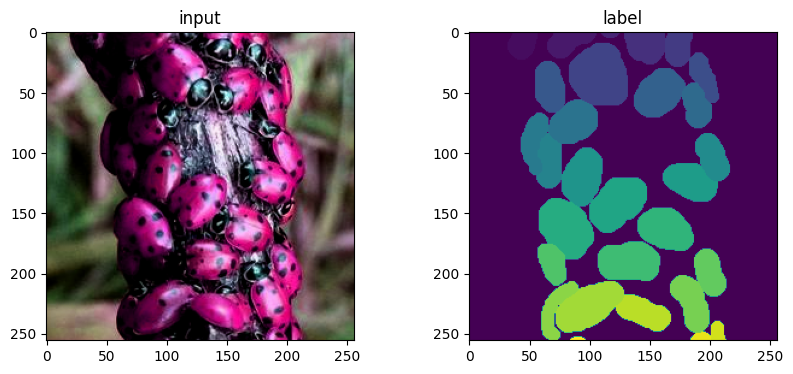

In [4]:

print(X[0].shape, Y[0].shape)
print(X[0].min(), X[0].max())
fig=imshow_multi2d([X[2], Y[2]], ['input', 'label'], 1,2)

## Divide into training and validation sets

Unlike stardist Cellpose does not seem to need numpy arrays as input.  So to create training and validation sets we can simply split the X and Y vectors. 

In [5]:

X_ = X.copy()
Y_ = Y.copy()

# note we don't have a lot of training patches so we will use them for both training and testing (very bad but this is just for proof of concept)

X_train = X_
Y_train = Y_
X_test = X_.copy()
Y_test = Y_.copy()

print('Number of images', len(X_))
print('Number of training images', len(X_train))
print('Number of test images ', len(X_test))



Number of images 735
Number of training images 735
Number of test images  735


In [6]:
X_train[0].shape, Y_train[0].shape

((256, 256, 3), (256, 256))

## Create a cellpose model

In [7]:
import os

model_name = 'cellpose_for_ladybugs'

# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model= models.CellposeModel(gpu=True, model_type=None)#, pretrained_model=os.path.join(model_path,model_name))

2024-10-22 14:48:42,171 [INFO] WRITING LOG OUTPUT TO /home/bnorthan/.cellpose/run.log
2024-10-22 14:48:42,172 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.12.4 
torch version:  	2.4.0+cu121
2024-10-22 14:48:42,252 [INFO] ** TORCH CUDA version installed and working. **
2024-10-22 14:48:42,252 [INFO] >>>> using GPU
2024-10-22 14:48:42,296 [INFO] >>>> no model weights loaded


# Train the model

In [8]:
from cellpose import train

channel_to_segment = 0 
optional_channel = 1

new_model_path = train.train_seg(model.net, X_train, Y_train, 
                              #test_data=X_val,
                              #test_labels=Y_val,
                              channels=[channel_to_segment,optional_channel], 
                              save_path=parent_path, 
                              n_epochs=50,
                              min_train_masks=0,
                              #learning_rate=learning_rate, 
                              #weight_decay=weight_decay, 
                              rescale = False,  
                              #nimg_per_epoch=400,
                              model_name=model_name,
                              normalize=False)

2024-10-22 14:48:47,193 [INFO] computing flows for labels


100%|██████████| 735/735 [00:10<00:00, 68.06it/s]

2024-10-22 14:48:58,100 [INFO] >>> computing diameters



100%|██████████| 735/735 [00:00<00:00, 5654.86it/s]

2024-10-22 14:48:58,231 [INFO] >>> using channels [2, 3]


2024-10-22 14:48:58,446 [INFO] >>> n_epochs=50, n_train=735, n_test=None
2024-10-22 14:48:58,446 [INFO] >>> AdamW, learning_rate=0.00500, weight_decay=0.00001
2024-10-22 14:48:59,241 [INFO] >>> saving model to /home/bnorthan/code/i2k/tnia/notebooks-and-napari-widgets-for-dl/data/ladybugs1/models/cellpose_for_ladybugs
2024-10-22 14:49:15,250 [INFO] 0, train_loss=3.1427, test_loss=0.0000, LR=0.0000, time 16.01s
2024-10-22 14:50:30,918 [INFO] 5, train_loss=1.2124, test_loss=0.0000, LR=0.0028, time 91.68s
2024-10-22 14:51:46,562 [INFO] 10, train_loss=0.5902, test_loss=0.0000, LR=0.0050, time 167.32s
2024-10-22 14:54:17,858 [INFO] 20, train_loss=0.3227, test_loss=0.0000, LR=0.0050, time 318.62s
2024-10-22 14:56:49,167 [INFO] 30, train_loss=0.2202, test_loss=0.0000, LR=0.0050, time 469.93s
2024-10-22 14:59:20,514 [INFO] 40, train_loss=0.1827, test_loss=0.0000, LR=0.0050, time 621.27s


## Test network on one of the training images (self prediction)

Self prediction is not a good way to evaluate the 'real' performance of the NN.  However it is good sanity test.  If the self prediction looks wrong something really went bad. 

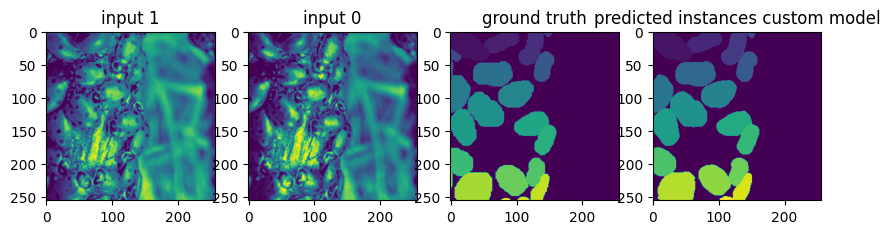

In [9]:

# run model on test images
n=50
masks = model.eval(X_train[n], channels=[channel_to_segment, optional_channel], cellprob_threshold=-1, flow_threshold=0.5, normalize=False)
fig = imshow_multi2d([X_train[n][:,:,channel_to_segment-1], X_train[n][:,:,optional_channel-1], Y_train[n], masks[0]],['input 1','input 0', 'ground truth','predicted instances custom model'],1,4)
